###Данные можно скачать здесь https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

In [ ]:
df = pd.read_csv("/content/12.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)
df.info()

<ipython-input-14-939972124b31>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("/content/12.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)
<ipython-input-14-939972124b31>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("/content/12.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ds                     datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


## Attribute Information

1. ds: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. globalactivepower: household global minute-averaged active power (in kilowatt)

4. globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [ ]:
print(f"Missing values: {df.isnull().sum().any()}")
for j in range(0,8):
  df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
print(f"Missing values: {df.isnull().sum().any()}")
print(df.shape)

Missing values: True
Missing values: False
(2075259, 8)


In [ ]:
df_resample = df.resample('D', on='ds').sum()
df_resample.rename(columns={"Global_active_power":"y"}, inplace=True)
df_resample = df_resample[['y']]
df_resample.head()

,y
ds,
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


In [ ]:
def create_lags(df, days=7):
    for i in range(days):
        df["Lag_{lag}".format(lag=i+1)] = df['y'].shift(i+1)
    return df

def create_features(X, time_steps=1, n_features=7):
    cols, names = list(), list()
    for i in range(1, time_steps+1):
        cols.append(X.shift(-time_steps))
        names += [name + "_" + str(i) for name in X.columns]
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    agg = agg.values.reshape(agg.shape[0], time_steps, n_features)
    return agg

def create_dataset(df, yhat):
    preds = pd.DataFrame(yhat.flatten())
    temp = pd.concat([df.iloc[:,0], preds])
    temp.columns = ['y']
    date_idx = pd.date_range(start='2006-12-23', periods=temp.shape[0])
    temp.set_index(date_idx, inplace=True)
    return temp

In [ ]:
chosen = df_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(chosen.iloc[:,1:])
y_scaled = scaler.fit_transform(chosen.iloc[:,0].values.reshape(-1,1))

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)
scaled.head()

,y,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
ds,,,,,,,,
2006-12-23,0.462304,0.324670,0.436748,0.313037,0.431901,0.694252,0.211996,1.000000
2006-12-24,1.000000,0.462304,0.324670,0.436748,0.313037,0.431901,0.694252,0.508439
2006-12-25,0.508439,1.000000,0.462304,0.324670,0.436748,0.313037,0.431901,0.551133
2006-12-26,0.551133,0.508439,1.000000,0.462304,0.324670,0.436748,0.313037,0.814446
2006-12-27,0.814446,0.551133,0.508439,1.000000,0.462304,0.324670,0.436748,0.282652


In [ ]:
train = scaled[:1096]
val = scaled[1096:1256]
test = scaled[1256:]
x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [ ]:
x_train_np = create_features(x_train, 7, 7)
x_val_np = create_features(x_val, 7, 7)
x_test_np = create_features(x_test, 7, 7)
y_test = y_test[:x_test_np.shape[0]]
y_train = y_train[:x_train_np.shape[0]]
y_val = y_val[:x_val_np.shape[0]]

In [ ]:
def fit_model(m, units, x_train_np, x_val_np, verbose=False):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [x_train_np.shape[1], x_train_np.shape[2]]))
    model.add(m (units = units))
    model.add(Dense(units = 1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(x_train_np, y_train, epochs=50, batch_size=70,
                        validation_data=(x_val_np, y_val), verbose=False, shuffle=False)
    return model

In [ ]:
RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

In [ ]:
RNN_preds = RNN_model.predict(x_test_np)
LSTM_preds = LSTM_model.predict(x_test_np)
GRU_preds = GRU_model.predict(x_test_np)

6/6 [==============================] - 1s 6ms/step


## 3.1 RNN

In [ ]:
resultsDict = {}

In [ ]:
import numpy as np

rnn_preds_actual = scaler.inverse_transform(RNN_preds)
y_test_actual = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

from sklearn.metrics import mean_absolute_error
mae_value = mean_absolute_error(y_test_actual, rnn_preds_actual)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_value = mean_absolute_percentage_error(y_test_actual, rnn_preds_actual)
from sklearn.metrics import mean_squared_error
mse_value = mean_squared_error(y_test_actual, rnn_preds_actual)

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 200 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape_value = symmetric_mean_absolute_percentage_error(y_test_actual, rnn_preds_actual)



print("MAE:", mae_value)
print("MAPE:", mape_value)
print("MSE:", mse_value)
print("SMAPE:", smape_value)

resultsDict['RNN'] = {'MAE': mae_value, 'MAPE': mape_value, 'MSE': mse_value, 'SMAPE': smape_value}

MAE: 229.74638334305467
MAPE: 17.6323785570945
MSE: 103886.96112928388
SMAPE: 17.029385714051777


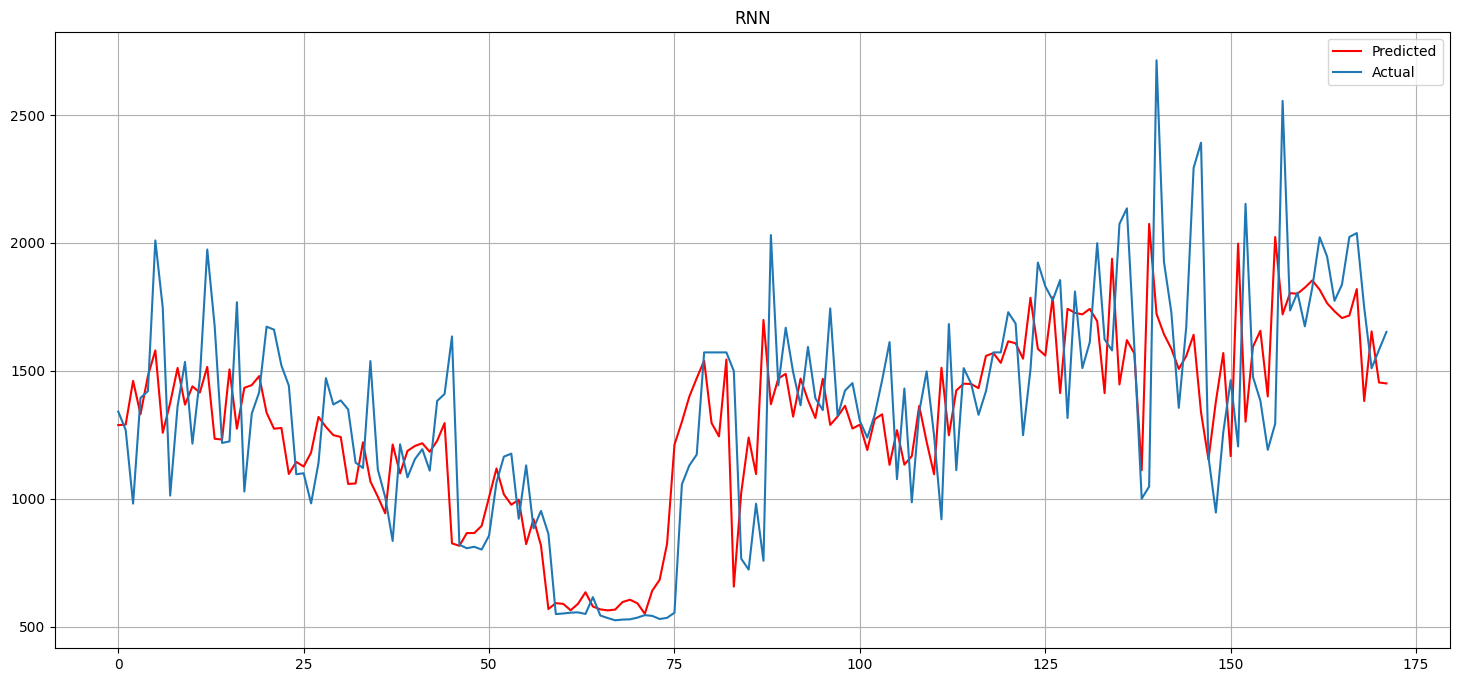

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(rnn_preds_actual, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('RNN')
plt.legend()
plt.grid(True)
plt.savefig('1 - RNN.jpg', dpi=200)
plt.show()

## 3.2 LSTM

In [ ]:
lstm_preds = scaler.inverse_transform(LSTM_preds)
y_test_actual = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
mae_value = mean_absolute_error(y_test_actual, lstm_preds)
mape_value = mean_absolute_percentage_error(y_test_actual, lstm_preds)
mse_value = mean_squared_error(y_test_actual, lstm_preds)
smape_value = symmetric_mean_absolute_percentage_error(y_test_actual, lstm_preds)
# Print the evaluation metrics
print("MAE:", mae_value)
print("MAPE:", mape_value)
print("MSE:", mse_value)
print("SMAPE:", smape_value)

# Store the results in the dictionary
resultsDict['LSTM'] = {'MAE': mae_value, 'MAPE': mape_value, 'MSE': mse_value, 'SMAPE': smape_value}

MAE: 243.93400199775638
MAPE: 20.356957247025868
MSE: 109514.14817852575
SMAPE: 18.166873873985153


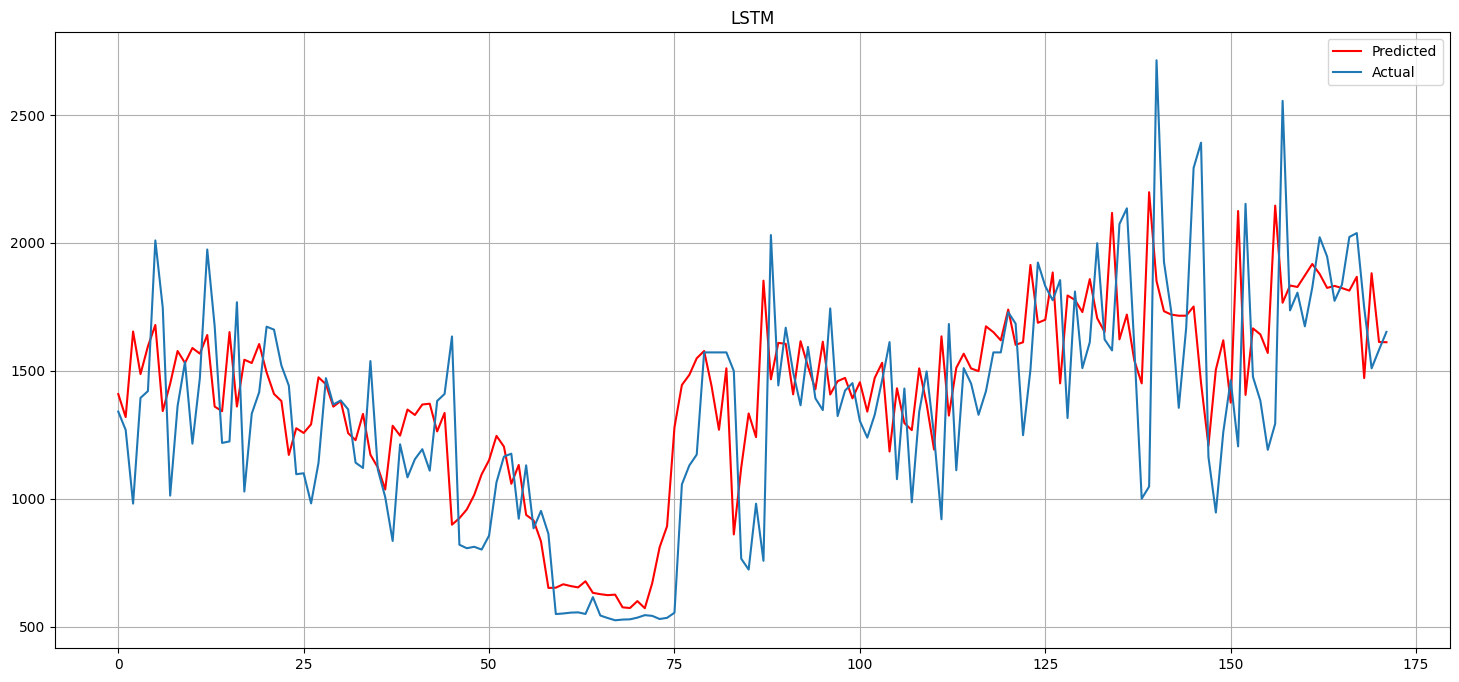

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(lstm_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.savefig('2 - LSTM.jpg', dpi=200)
plt.show()

## 3.3 GRU

In [ ]:
gru_preds = scaler.inverse_transform(GRU_preds)
y_test_actual = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
mae_value = mean_absolute_error(y_test_actual, gru_preds)
mape_value = mean_absolute_percentage_error(y_test_actual, gru_preds)
mse_value = mean_squared_error(y_test_actual, gru_preds)
smape_value = symmetric_mean_absolute_percentage_error(y_test_actual, gru_preds)
# Print the evaluation metrics
print("MAE:", mae_value)
print("MAPE:", mape_value)
print("MSE:", mse_value)
print("SMAPE:", smape_value)

# Store the results in the dictionary
resultsDict['GRU'] = {'MAE': mae_value, 'MAPE': mape_value, 'MSE': mse_value, 'SMAPE': smape_value}

MAE: 236.49213876303654
MAPE: 19.304146444182415
MSE: 105328.9890236058
SMAPE: 17.54643755886181


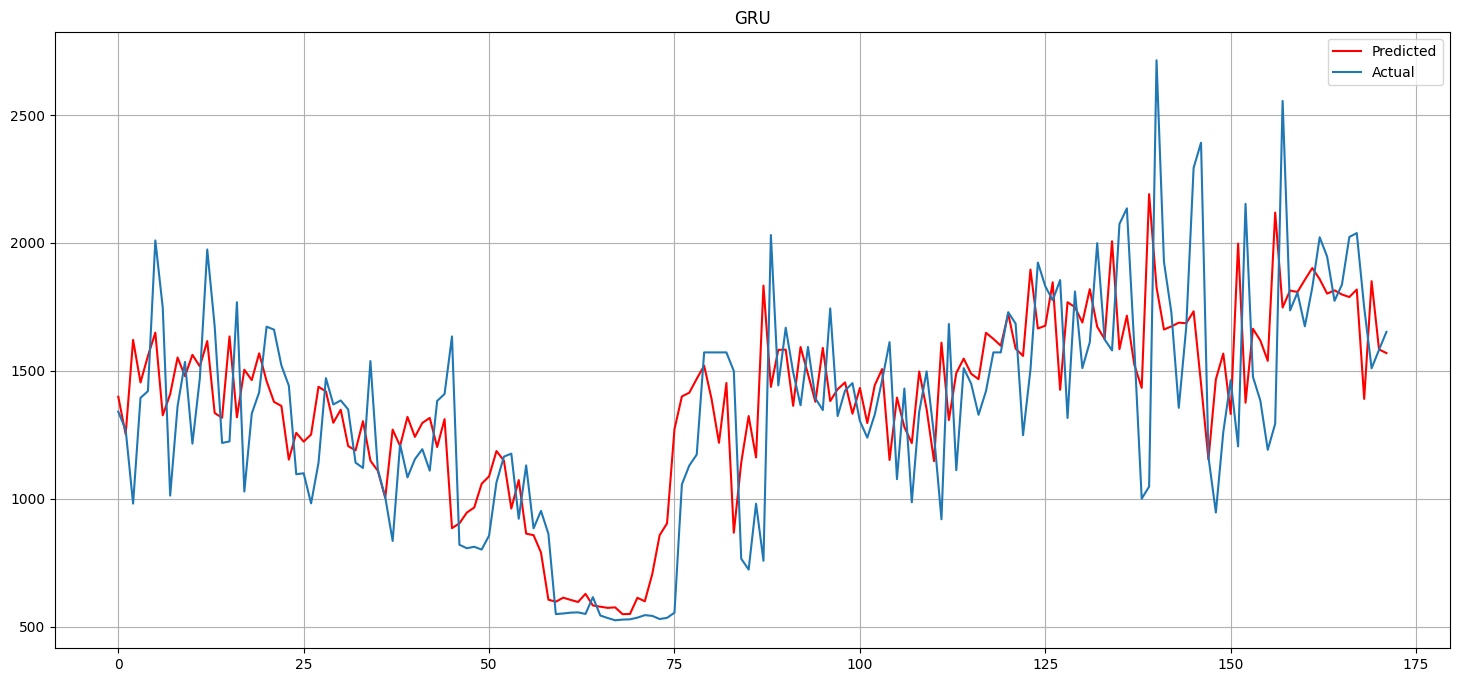

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(gru_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('GRU')
plt.legend()
plt.grid(True)
plt.savefig('3 - GRU.jpg', dpi=200)
plt.show()